In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from Preprocess_EDA import *

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew

from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.colors import rgb2hex, colorConverter
from scipy.cluster.hierarchy import set_link_color_palette
import pandas as pd
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

In [13]:
def process_data():
    # read data
    df = integrate_clean_data()
    # create the date interval between treading date and published date
    df['pubToTreDays'] = (df['trendingDate'] - df['publishDate']).dt.days

    # keep numerical features
    data = df.drop(['title', 'publishedAt', 'channelTitle', 'categoryId', 
                    'trending_date', 'tags', 'description', 'country', 
                    'publishDate', 'publishTime', 'trendingDate', 'title_lst', 
                    'tags_lst'], axis = 'columns')

    # only keep the first trending date for each video
    data = data.drop_duplicates(subset = ['video_id'], keep = 'first')

    # subset numeric features for later clustering
    numbers = data[['view_count', 'likes', 'dislikes', 'comment_count', 
                    'comments_disabled', 'ratings_disabled', 'pubToTreDays']]

    # one-hot encoding for boolean values: comments_disabled, ratings_disabled
    # used LabelEncoder since there's only 2 categories for each column, 
    # after drop one column using one hot encoding, the result is the same.
    labelencoder = LabelEncoder()
    numbers['comments_disabled'] = labelencoder.fit_transform(numbers['comments_disabled'])
    numbers['ratings_disabled'] = labelencoder.fit_transform(numbers['ratings_disabled'])

    # For normally distributed data, the skewness should be about zero
    # greater than zero means that there is more weight in the right tail of the distribution
    skewed_feats = numbers.apply(lambda x: skew(x)) # compute skewness
    skewed_feats = skewed_feats[(skewed_feats > 0.75) | (skewed_feats < -0.75)]
    skewed_feats = skewed_feats.index
    # log to help with the skewness
    # the natural logarithm of one plus the input array, element-wise
    numbers[skewed_feats] = np.log1p(numbers[skewed_feats])

    # use StandardScaler z = (x - u) / s where u is the mean of the training samples 
    # and s is the standard deviation of the training samples 
    scaler = StandardScaler()
    numbers_scaled = scaler.fit_transform(numbers)
    return data, numbers, numbers_scaled


def dendrogram_ytb(linkage = 'ward'):
    data, numbers, numbers_scaled = process_data()
    # The dendrogram illustrates how each cluster is composed by drawing a U-shaped link between a non-singleton cluster and its children.
    plt.figure(figsize=(20, 7))
    plt.title("Youtube Trending Video Dendograms")
    plt.xticks(rotation='vertical')
    dend_ward = shc.dendrogram(shc.linkage(numbers_scaled, method = linkage))
    
    
def agglomerative_clustering(cluster_num, linkage):
    data, numbers, numbers_scaled = process_data()
    agc = AgglomerativeClustering(n_clusters = cluster_num, affinity = 'euclidean',  
                                  compute_full_tree = 'auto', linkage = linkage)
    # attach the belonged cluster number to each row of the original data
    data['ag_cluster']= agc.fit_predict(numbers_scaled)
    return data


def countplot_cluster():
    # size of each cluster
    plt.figure(figsize=(15,5))
    sns.countplot(x = "ag_cluster", data = data_c, palette = 'PuBuGn')

    plt.style.use('seaborn')
    sns.set_style('whitegrid')
    plt.ylabel("Count",fontsize=14, weight = 'bold')
    plt.xlabel('Agglomerative Clusters', fontsize = 14, weight = 'bold')
    plt.show()
    
    
def scatter_plot():
    # relationship the numerical variables have with view_count
    attributes = ["likes", "dislikes", "comment_count", 'pubToTreDays']

    fig, axes = plt.subplots(2, 2, figsize = (9, 9))
    plt.suptitle("Scatter Plots of Numercial Features VS view_count", fontsize = 18)
    plt.subplots_adjust(hspace=0.88, wspace= .3)

    axes = axes.ravel()
    for a, ax in zip(attributes, axes):
        sns.scatterplot(data = data_c, x = a, y = 'view_count', hue = 'ag_cluster', 
                     alpha=0.6, ax = ax)

    fig.tight_layout()
    plt.show()
    
    
def plot_important_matrices():
    # set figure size
    fig = plt.figure(figsize = (12, 6))
    sns.set_style("whitegrid")
    # median publised to trending date difference for each cluster
    plt.subplot(1, 2, 1)
    data_c.groupby(['ag_cluster']).median()['pubToTreDays'].plot(kind='bar', color = 'orchid')
    plt.xlabel('Clusters', fontsize = 14)
    plt.title('Median of difference between \ntrending/publised days', fontsize = 18)

    # average likes
    plt.subplot(1, 2, 2)
    data_c.groupby(['ag_cluster']).sum()['likes'].plot(kind='bar', color = 'orchid')
    plt.xlabel('Clusters', fontsize = 14)
    plt.title('Mean of likes', fontsize = 18)
    plt.show()
    
    
def plot_wordcloud(cluster):
    wordcloud0 = WordCloud(collocations = True, width=400, height=300, 
                           background_color='white', 
                           colormap = 'spring').generate(' '.join(cluster['category']))
    plt.imshow(wordcloud0, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

Which linkage criterion to use:

‘ward’ minimizes the variance of the clusters being merged.

‘average’ uses the average of the distances of each observation of the two sets.

‘complete’ or ‘maximum’ linkage uses the maximum distances between all observations of the two sets.

‘single’ uses the minimum of the distances between all observations of the two sets.

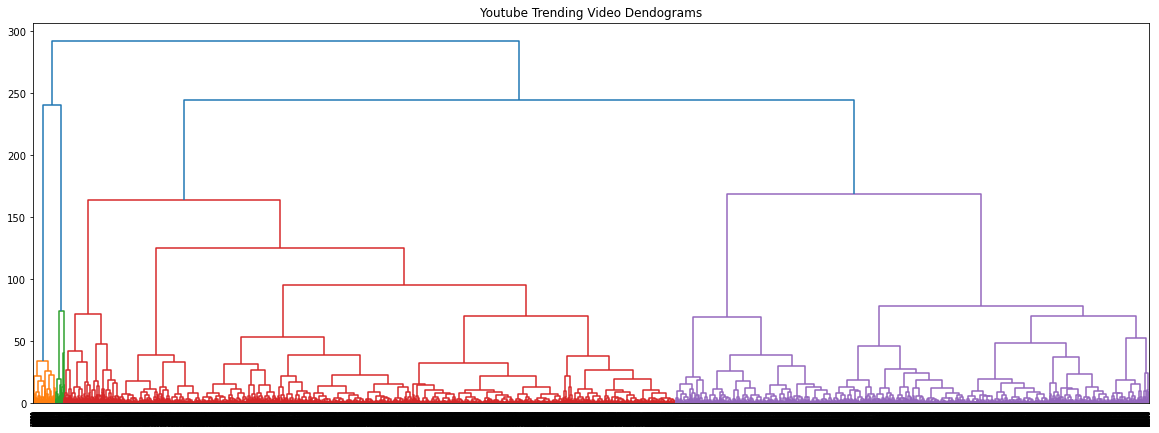

In [3]:
dendrogram_ytb(linkage = 'ward')

This dendogram gives us an idea on how the algorithm clusters the data, it shows 4 different clusters of different sizes, the red cluster is very small in comparison to the green. For the sake of finding sub-clusters inside of big clusters, I will start my analysis with 8 clusters instead of 4. The idea is to split the green and cean clusters into 2 or 3 sub-clusters.

The ideal method to find the right number of clusters would be to try the measurement: Within Cluster Sum of Squares (WCSS), which measures the squared average distance of all the points within a cluster to the cluster centroid. (The Euclidean distance between a given point and the centroid to which it is assigned)

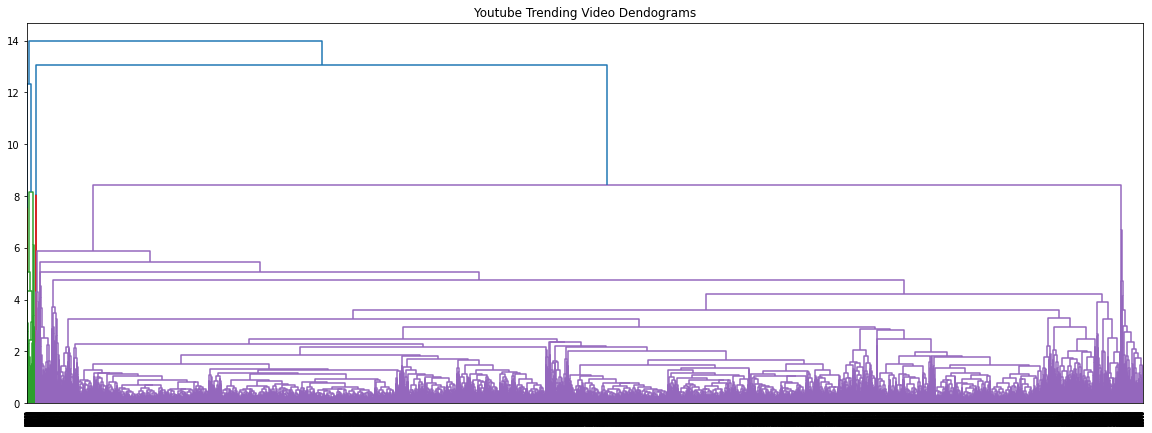

In [4]:
dendrogram_ytb(linkage = 'average')

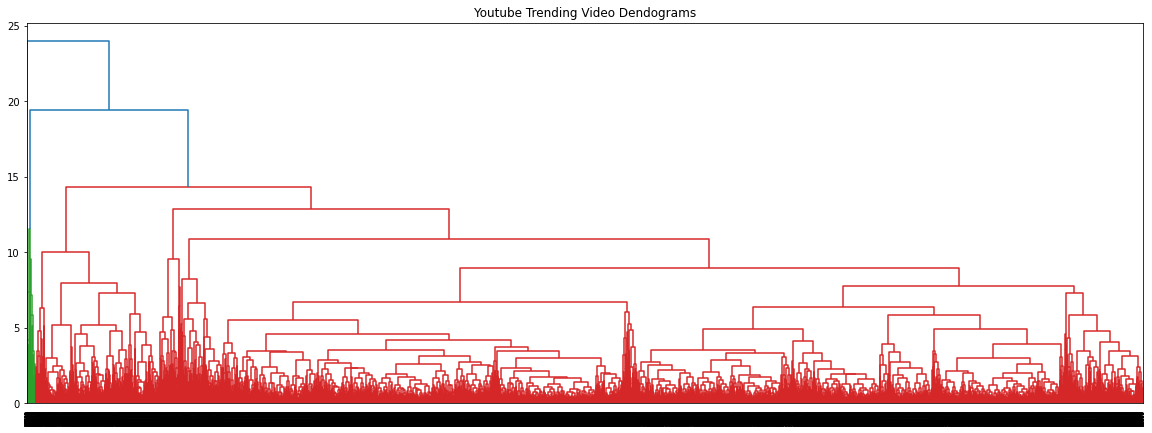

In [5]:
dendrogram_ytb(linkage = 'complete')

In [6]:
cluster_num = 7
linkage = 'ward'
data_c = agglomerative_clustering(cluster_num, linkage)

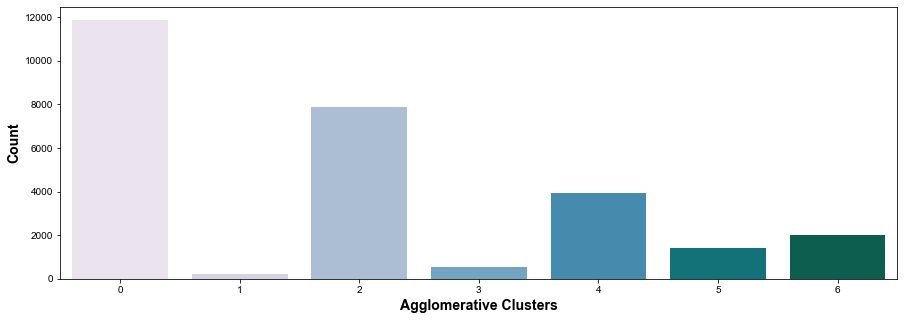

In [7]:
countplot_cluster()

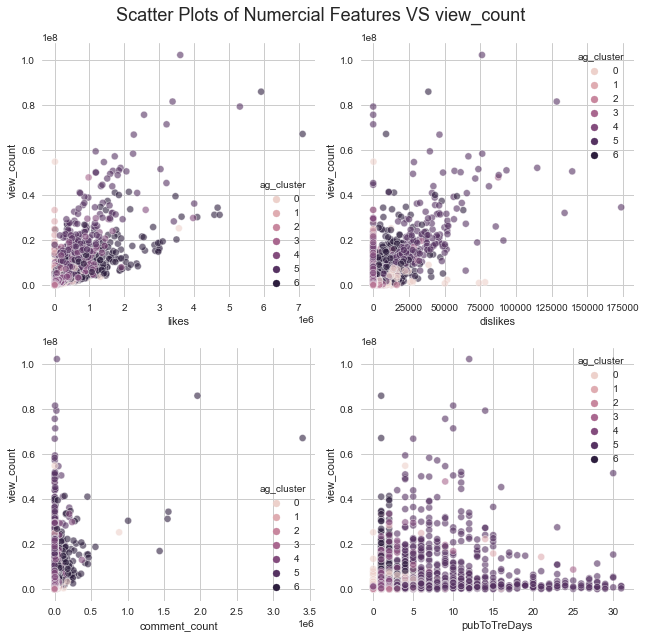

In [8]:
scatter_plot()

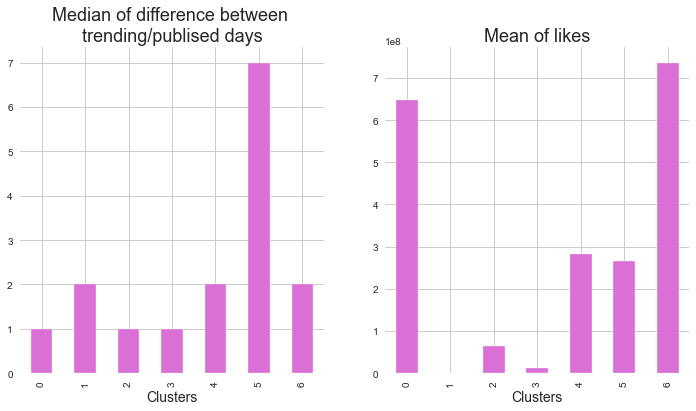

In [14]:
plot_important_matrices()

cluster 0


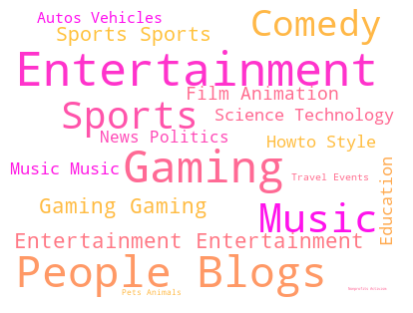

cluster 1


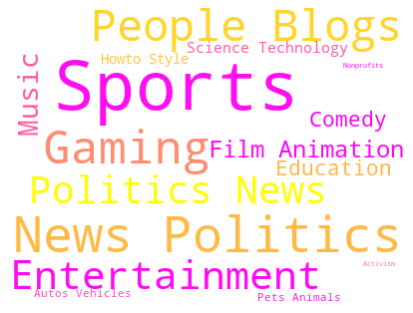

cluster 2


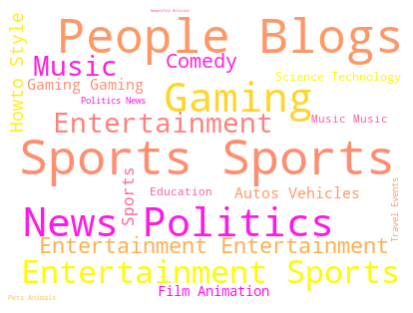

cluster 3


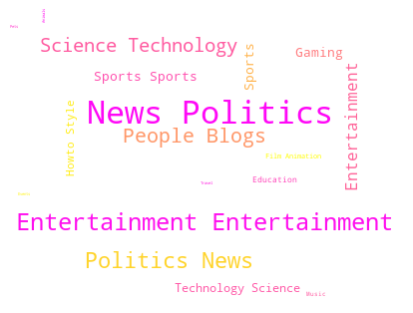

cluster 4


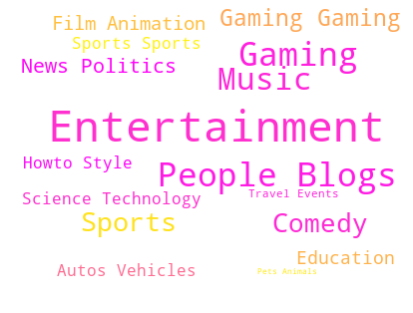

cluster 5


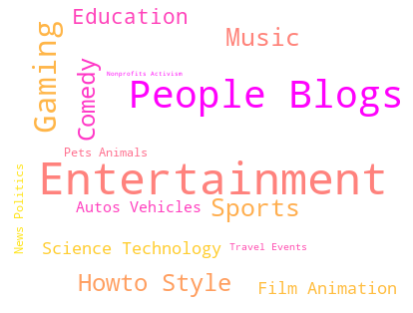

cluster 6


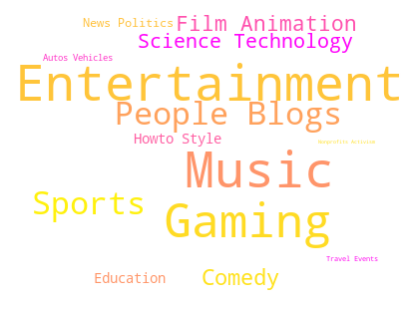

In [15]:
for i in range(cluster_num):
    agcluster = data_c[data_c['ag_cluster'] == i]
    print('cluster', i)
    plot_wordcloud(agcluster)